In [2]:
import torchvision.transforms as T
from importlib import reload
import torch
import object_detection_data
from PIL import Image, ImageDraw
import itertools
import numpy as np

reload(object_detection_data)
import object_detection_data
import object_detection_models
import torch.nn.functional as F


In [44]:
def scalings(
    initial_quadratic_scaling,
    initial_rectangular_scaling,
    number_of_quadratic,
    number_of_rectangular,
):
    return torch.row_stack(
        (
            initial_quadratic_scaling
            / torch.arange(0, number_of_quadratic).reshape((-1, 1)),
            initial_rectangular_scaling
            / torch.arange(0, number_of_rectangular).reshape((-1, 1)),
        )
    )

# TODO: Parametrize by aspect ratio
default_scalings = scalings(torch.tensor([0.5, 0.5]), torch.tensor([0.25, 0.75]), 5, 2)
# height x width
feature_map_size = (16, 20)
num_classes = 4
encoder = object_detection_data.Encoder(default_scalings, feature_map_size, num_classes)
transformed_data = object_detection_data.TransformedDataset("data/train", encoder)
# data_path = 'data/train'
# transforms = T.Compose([T.Grayscale(), T.PILToTensor(), T.ConvertImageDtype(
#     torch.float32), T.Resize((60, 80))])
# transformed_train_data = object_detection_data.ObjectDetectionDataset(
#     'data/train', encoder, image_transforms=transforms)
# model = object_detection_models.MultiClassJetNet(num_classes, default_scalings.size(0))


In [45]:
def tensor_to_pil(image, normalize):
    image = image * normalize[1] + normalize[0]
    return T.ToPILImage()(image)


def draw_bounding_box(image, bounding_boxes):
    image_draw = ImageDraw.Draw(image)
    for i in range(bounding_boxes.size(0)):
        cx = int(bounding_boxes[i][0] * image.size[0])
        cy = int(bounding_boxes[i][1] * image.size[1])
        w = int(bounding_boxes[i][2] * image.size[0])
        h = int(bounding_boxes[i][3] * image.size[1])
        xy = [cx - w // 2, cy - h // 2, cx + w // 2, cy + h // 2]
        image_draw.rectangle(xy)
    return image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


normalize = torch.load("data/train/image_normalize.pt")


data_iter = iter(transformed_data)


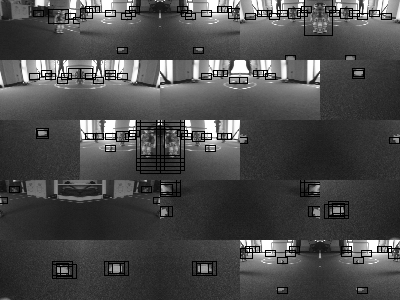

In [63]:
# TODO: Visualize the default boxes!
pil_iamges = []
rows = 5
cols = 5
for i in range(rows * cols):
    (
        image,
        encoded_bounding_boxes,
        target_masks,
        encoded_object_classes,
        idx,
    ) = next(data_iter)
    # decoded_target_box = encoder.decode_bounding_boxes(encoded_bounding_boxes, target_masks)
    draw = draw_bounding_box(
        tensor_to_pil(image, normalize),
        encoder.default_boxes_xy_wh[target_masks],
    )
    pil_iamges.append(draw)

image_grid(pil_iamges, rows, cols).save(
    "../../phd/jonathan-hellwig.github.io/assets/img/transformed.png"
)
image_grid(pil_iamges, rows, cols)


In [5]:
raw_data = object_detection_data.ObjectDetectionDataset('data/train')
raw_data_iter = iter(raw_data)

In [37]:
# TODO: Visualize the default boxes!
raw_iamges = []
for i in range(1):
    (image, target_bounding_box, target_class) = next(raw_data_iter)
    # decoded_target_box = encoder.decode_bounding_boxes(encoded_bounding_boxes, target_masks)
    draw = draw_bounding_box(
        image, target_bounding_box
    )
    raw_iamges.append(draw)
image_grid(raw_iamges, 1, 1).save('../../phd/jonathan-hellwig.github.io/assets/img/raw_image.png')
image_grid(raw_iamges, 1, 1)

NameError: name 'raw_data_iter' is not defined

In [ ]:
import torch.nn.functional as F

data_iter = iter(transformed_train_data)

image, encoded_bounding_boxes, target_masks, encoded_object_classes = next(data_iter)
encoded_object_classes.sum()
predicted_boxes, predicted_class_logits = pl_model(image.unsqueeze(0))
probs = F.softmax(predicted_class_logits, dim=1)
pre_nll = (1 - probs) * torch.log(probs)
F.nll_loss(pre_nll, encoded_object_classes)


tensor([[0.5499]])